In [65]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison



In [33]:
data_df = pd.read_csv('Culled Wildfires 2000-2015.csv')

data_df = data_df.loc[(data_df['STATE'] != 'AK') & (data_df['STATE'] != 'HI') & (data_df['STATE'] != 'PR')]

In [34]:
data_df.head()

,FIRE_DISC_DATE,FIRE_CONT_DATE,FIRE_DURATION,FIRE_SIZE_CLASS,FIRE_SIZE,STAT_CAUSE_DESCR,STATE,LATITUDE,LONGITUDE,FIRE_YEAR_DISC,FIRE_MONTH_DISC
0,2000-01-01,2000-01-20,19,B,5.0,Debris Burning,CA,36.448910,-118.738110,2000,1
1,2000-01-01,2000-01-05,4,D,250.0,Debris Burning,OK,34.710278,-94.866111,2000,1
2,2000-01-01,2000-01-02,1,F,1200.0,Miscellaneous,TX,35.704200,-101.545600,2000,1
3,2000-01-01,2000-01-02,1,G,7320.0,Fireworks,OK,36.376500,-96.292200,2000,1
4,2000-01-03,2000-01-04,1,A,0.1,Powerline,WV,38.367662,-82.216708,2000,1


## Box Plot Comparison of Fire Size by Cause

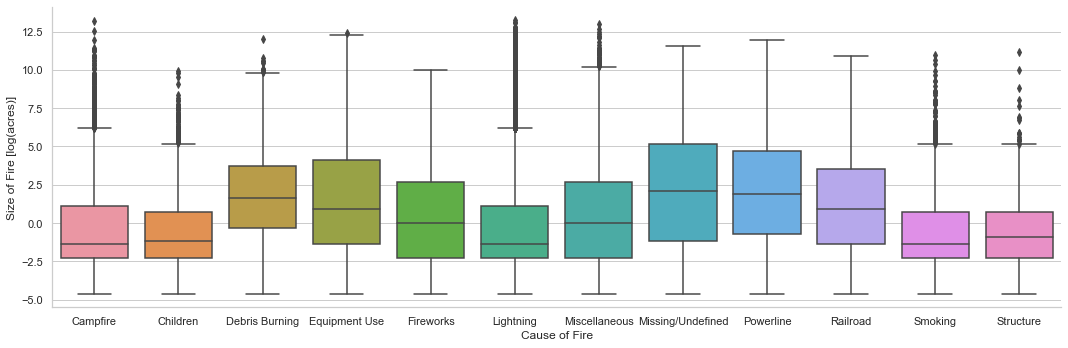

In [75]:
causeSort = data_df.sort_values(by=['STAT_CAUSE_DESCR'])
causeSort['LOG_SIZE'] = np.log(causeSort['FIRE_SIZE'])
sns.set(style="whitegrid")
g = sns.catplot(x="STAT_CAUSE_DESCR",y="LOG_SIZE",data=causeSort,kind='box',height=5,aspect=3)
g.set_axis_labels("Cause of Fire", "Size of Fire [log(acres)]")

## Investigating statistical differences in fire sizes

In [76]:
causeSize_df = pd.DataFrame({'FIRE_SIZE' : data_df['FIRE_SIZE'], 'CAUSE' : data_df['STAT_CAUSE_DESCR']})

In [52]:
causeSizedrop = causeSize_df.dropna(subset=['CAUSE']).sort_values(by=['CAUSE']).reset_index(drop=False)
causeCount = causeSize_df.groupby(['CAUSE'])
causeCount.describe()

FIRE_SIZE                                               \
                      count        mean          std   min     25%   50%   
CAUSE                                                                      
Campfire             6340.0  416.948268  8448.541781  0.01  0.1000  0.25   
Children             1548.0   79.244612   842.340428  0.01  0.1000  0.30   
Debris Burning       8620.0  183.727825  2174.491986  0.01  0.7375  5.00   
Equipment Use        4138.0  758.855860  7142.880233  0.01  0.2500  2.50   
Fireworks            1040.0  153.000731  1047.852330  0.01  0.1000  1.00   
Lightning           73154.0  558.660391  7144.057603  0.01  0.1000  0.25   
Miscellaneous       15726.0  504.181498  6573.553043  0.01  0.1000  1.00   
Missing/Undefined    3698.0  626.812818  3765.467908  0.01  0.3000  8.00   
Powerline            1057.0  869.414040  6160.766754  0.01  0.5000  6.50   
Railroad              596.0  278.645705  2418.423520  0.01  0.2500  2.50   
Smoking              1564.0  176.201343  2159.093679  0.01  0.1000  0.25   
Structure             319.0  344.496113  4091.417694  0.01  0.1000  0.40   

                                     
                      75%       max  
CAUSE                                
Campfire             3.00  538049.0  
Children             2.00   21135.0  
Debris Burning      42.00  162702.0  
Equipment Use       61.00  240207.0  
Fireworks           15.00   22454.0  
Lightning            3.00  558198.3  
Miscellaneous       15.00  427696.0  
Missing/Undefined  175.75  108204.0  
Powerline          111.00  156593.0  
Railroad            35.00   55261.0  
Smoking              2.00   58501.0  
Structure            2.00   69363.0

#### Looking at the above table, we don't have homogeneity of variance, and judging by the amount of tail-end outliers in our box plot, we don't have normality either. However, the distributions are similarly shaped, so we can still proceed with some variants of ANOVA testing, just with loss of power.



---

In [60]:
causeList = []
sizeList = []
i = 0
for cause in causeSizedrop['CAUSE']:
    if cause not in causeList:
        causeList.append(cause)
        sizeList.append([])
        for size in causeSizedrop.loc[causeSizedrop['CAUSE'] == cause]['FIRE_SIZE']:
            sizeList[i].append(size)
        i += 1
print(len(causeList))

12


In [63]:
stats.f_oneway(sizeList[0],sizeList[1],sizeList[2],sizeList[3],sizeList[4],sizeList[5],sizeList[6],sizeList[7],sizeList[8],sizeList[9],sizeList[10],sizeList[11])

F_onewayResult(statistic=4.555074078519759, pvalue=6.012815703987872e-07)

In [64]:
stats.kruskal(sizeList[0],sizeList[1],sizeList[2],sizeList[3],sizeList[4],sizeList[5],sizeList[6],sizeList[7],sizeList[8],sizeList[9],sizeList[10],sizeList[11])

C:\Users\Cuno\AppData\Local\Continuum\anaconda3\envs\geopandas\lib\site-packages\scipy\stats\stats.py:5879: RuntimeWarning: overflow encountered in long_scalars
  h = 12.0 / (totaln * (totaln + 1)) * ssbn - 3 * (totaln + 1)


KruskalResult(statistic=4897280.591228835, pvalue=0.0)

F_oneway assumes normality and homogeneity, whereas Kruskal-Wallis only assumes homogeneity. Both indicate that at least one of our fire causes is significantly different than the others.

f-test p-value:  6.01e-07
Kruskal p-value: Too small to calculate (~=0)


---

The below test effect does paired t-tests on every subset of fire causes to see where the difference indicated by the ANOVA testing lies. The pairs that reject the null hypothesis at alpha=0.05 are:
Children - Equipment Use
Debris Burning - Equipment Use
Debris Burning - Lightning
Debris Burning - Miscellaneous
Debris Burning - Missing/Undefined

Given this, our conclusion is that Debris Burning caused fires are differently sized than other fire causes.

In [68]:
mc = MultiComparison(causeSizedrop['FIRE_SIZE'],causeSizedrop['CAUSE'])
mc_results = mc.tukeyhsd()
print(mc_results)

              Multiple Comparison of Means - Tukey HSD, FWER=0.05               
      group1            group2       meandiff p-adj    lower      upper   reject
--------------------------------------------------------------------------------
         Campfire          Children -337.7037 0.8014  -954.9824  279.5751  False
         Campfire    Debris Burning -233.2204 0.5954  -593.4634  127.0226  False
         Campfire     Equipment Use  341.9076 0.2985   -93.2307  777.0459  False
         Campfire         Fireworks -263.9475    0.9  -992.3894  464.4943  False
         Campfire         Lightning  141.7121    0.9  -143.3448   426.769  False
         Campfire     Miscellaneous   87.2332    0.9  -236.6855   411.152  False
         Campfire Missing/Undefined  209.8645    0.9  -240.6653  660.3944  False
         Campfire         Powerline  452.4658 0.6404  -270.9262 1175.8578  False
         Campfire          Railroad -138.3026    0.9  -1071.159  794.5538  False
         Campfire           